<a href="https://colab.research.google.com/github/Mahmood-Anaam/translate-a-dataset/blob/main/translate_a_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import all libraries

In [1]:
import json
import random
import skimage.io as io
import matplotlib.pyplot as plt
import os
import datetime
import copy

# Download and explore the original dataset

 [visualqa](https://visualqa.org/)

In [ ]:
versionType  ="v2"          #VQA v2.0 dataset
taskType    ='OpenEnded'    #type of annotations in the JSON file (OpenEnded).
dataType    ='mscoco'       #source of the images (mscoco or abstract_v002).
dataSubType = "train2014"   #type of data subtype (e.g. train2014/val2014/test2015 for mscoco, train2015/val2015 for abstract_v002).

questionsName = f"{versionType}_Questions_Train_{dataType}"
annotationsName = f"{versionType}_Annotations_Train_{dataType}"
imagesName = dataSubType



## Download

In [ ]:
!mkdir original-dataset

In [ ]:
%cd /content/original-dataset/

/content/original-dataset


In [ ]:
questionsLink = f"https://s3.amazonaws.com/cvmlp/vqa/{dataType}/vqa/{questionsName}.zip"
!wget {questionsLink}
!unzip -q {questionsName+".zip"}
!rm {questionsName+".zip"}

--2024-04-22 14:24:20--  https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.169.160, 52.216.48.224, 52.217.140.152, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.169.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7239401 (6.9M) [application/zip]
Saving to: ‘v2_Questions_Train_mscoco.zip’

v2_Questions_Train_ 100%[===================>]   6.90M  38.7MB/s    in 0.2s    

2024-04-22 14:24:21 (38.7 MB/s) - ‘v2_Questions_Train_mscoco.zip’ saved [7239401/7239401]



In [ ]:
annotationsLink = f"https://s3.amazonaws.com/cvmlp/vqa/{dataType}/vqa/{annotationsName}.zip"
!wget {annotationsLink}
!unzip -q {annotationsName+".zip"}
!rm {annotationsName+".zip"}

--2024-04-22 14:24:21--  https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.169.160, 52.216.48.224, 52.217.140.152, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.169.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21708861 (21M) [application/zip]
Saving to: ‘v2_Annotations_Train_mscoco.zip’

v2_Annotations_Trai 100%[===================>]  20.70M  63.8MB/s    in 0.3s    

2024-04-22 14:24:22 (63.8 MB/s) - ‘v2_Annotations_Train_mscoco.zip’ saved [21708861/21708861]



In [ ]:
imagesLink = f"http://images.cocodataset.org/zips/{imagesName}.zip"
!wget {imagesLink}
!unzip -q {imagesName+".zip"}
!rm {imagesName+".zip"}

--2024-04-22 13:38:01--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.30.7, 3.5.29.237, 52.216.29.44, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.30.7|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  63.3MB/s    in 2m 53s  

2024-04-22 13:40:54 (74.4 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]





---

## Explore



In [ ]:
quesFile     = f"{versionType}_{taskType}_{dataType}_{dataSubType}_questions.json"
annFile     = f"{versionType}_{dataType}_{dataSubType}_annotations.json"
imgDir 		  = imagesName

In [ ]:
class VQA:

  def __init__(self, annotation_file=None, question_file=None):
    """
    Constructor of VQA helper class for reading and visualizing questions and answers.
    :param annotation_file (str): location of VQA annotation file
    :return:
    """
    # load dataset
    self.dataset = {}
    self.questions = {}
    self.qa = {}
    self.qqa = {}
    self.imgToQA = {}
    if not annotation_file == None and not question_file == None:
      print('loading VQA annotations and questions into memory...')
      time_t = datetime.datetime.utcnow()
      dataset = json.load(open(annotation_file, 'r'))
      questions = json.load(open(question_file, 'r'))
      print(datetime.datetime.utcnow() - time_t)
      self.dataset = dataset
      self.annotations = dataset
      self.questions = questions
      self.createIndex()


  def createIndex(self):
    # create index
    print ('creating index...')
    imgToQA = {ann['image_id']: [] for ann in self.dataset['annotations']}
    qa =  {ann['question_id']:       [] for ann in self.dataset['annotations']}
    qqa = {ann['question_id']:       [] for ann in self.dataset['annotations']}

    for ann in self.dataset['annotations']:
      imgToQA[ann['image_id']] += [ann]
      qa[ann['question_id']] = ann

    for ques in self.questions['questions']:
      qqa[ques['question_id']] = ques

    print('index created!')

    # create class members
    self.qa = qa
    self.qqa = qqa
    self.imgToQA = imgToQA

  def info(self):
    """
    Print information about the VQA annotation file.
    :return:
    """
    for key, value in self.dataset['info'].items():
      print (f'%s: %s'%(key, value))

  def getQuesIds(self, imgIds=[], quesTypes=[], ansTypes=[]):
    """
    Get question ids that satisfy given filter conditions. default skips that filter
    :param 	imgIds    (int array)   : get question ids for given imgs
    quesTypes (str array)   : get question ids for given question types
    ansTypes  (str array)   : get question ids for given answer types
    :return:    ids   (int array)   : integer array of question ids
    """
    imgIds 	  = imgIds    if type(imgIds)    == list else [imgIds]
    quesTypes = quesTypes if type(quesTypes) == list else [quesTypes]
    ansTypes  = ansTypes  if type(ansTypes)  == list else [ansTypes]

    if len(imgIds) == len(quesTypes) == len(ansTypes) == 0:
      anns = self.dataset['annotations']
    else:
      if not len(imgIds) == 0:
             anns = sum([self.imgToQA[imgId] for imgId in imgIds if imgId in self.imgToQA],[])
      else:
             anns = self.dataset['annotations']

      anns = anns if len(quesTypes) == 0 else [ann for ann in anns if ann['question_type'] in quesTypes]
      anns = anns if len(ansTypes)  == 0 else [ann for ann in anns if ann['answer_type'] in ansTypes]

    ids = [ann['question_id'] for ann in anns]
    return ids

  def getImgIds(self, quesIds=[], quesTypes=[], ansTypes=[]):
    """
    Get image ids that satisfy given filter conditions. default skips that filter
    :param quesIds   (int array)   : get image ids for given question ids
        quesTypes (str array)   : get image ids for given question types
        ansTypes  (str array)   : get image ids for given answer types
    :return: ids     (int array)   : integer array of image ids
    """
    quesIds   = quesIds   if type(quesIds)   == list else [quesIds]
    quesTypes = quesTypes if type(quesTypes) == list else [quesTypes]
    ansTypes  = ansTypes  if type(ansTypes)  == list else [ansTypes]

    if len(quesIds) == len(quesTypes) == len(ansTypes) == 0:
             anns = self.dataset['annotations']
    else:
             if not len(quesIds) == 0:
                nns = sum([self.qa[quesId] for quesId in quesIds if quesId in self.qa],[])
             else:
                anns = self.dataset['annotations']

             anns = anns if len(quesTypes) == 0 else [ann for ann in anns if ann['question_type'] in quesTypes]
             anns = anns if len(ansTypes)  == 0 else [ann for ann in anns if ann['answer_type'] in ansTypes]
    ids = [ann['image_id'] for ann in anns]
    return ids

  def loadQA(self, ids=[]):
    """
    Load questions and answers with the specified question ids.
    :param ids (int array)       : integer ids specifying question ids
    :return: qa (object array)   : loaded qa objects
    """
    if type(ids) == list:
             return [self.qa[id] for id in ids]
    elif type(ids) == int:
             return [self.qa[ids]]

  def showQA(self, anns):
    """
    Display the specified annotations.
    :param anns (array of object): annotations to display
    :return: None
    """
    if len(anns) == 0:
             return 0
    for ann in anns:
             quesId = ann['question_id']
             print ("Question: %s" %(self.qqa[quesId]['question']))
             for ans in ann['answers']:
                print ("Answer %d: %s" %(ans['answer_id'], ans['answer']))
             print ("Multiple Choice Answer: %s" %(ann['multiple_choice_answer']))

  def loadRes(self, resFile, quesFile):

    """
    Load result file and return a result object.
    :param   resFile (str)     : file name of result file
    :return: res (obj)         : result api object
    """
    res = VQA()
    res.questions = json.load(open(quesFile))
    res.dataset['info'] = copy.deepcopy(self.questions['info'])
    res.dataset['task_type'] = copy.deepcopy(self.questions['task_type'])
    res.dataset['data_type'] = copy.deepcopy(self.questions['data_type'])
    res.dataset['data_subtype'] = copy.deepcopy(self.questions['data_subtype'])
    res.dataset['license'] = copy.deepcopy(self.questions['license'])

    print ('Loading and preparing results...     ')
    time_t = datetime.datetime.utcnow()
    anns    = json.load(open(resFile))
    assert type(anns) == list, 'results is not an array of objects'
    annsQuesIds = [ann['question_id'] for ann in anns]
    assert set(annsQuesIds) == set(self.getQuesIds()),'Results do not correspond to current VQA set.'
    for ann in anns:
      quesId 			     = ann['question_id']
      qaAnn                = self.qa[quesId]
      if res.dataset['task_type'] == 'Multiple Choice':
        assert ann['answer'] in self.qqa[quesId]['multiple_choices'], 'predicted answer is not one of the multiple choices'
      ann['image_id']      = qaAnn['image_id']
      ann['question_type'] = qaAnn['question_type']
      ann['answer_type']   = qaAnn['answer_type']

    print ('DONE (t=%0.2fs)'%((datetime.datetime.utcnow() - time_t).total_seconds()))
    res.dataset['annotations'] = anns
    res.createIndex()
    res.createIndex()

    return res


In [ ]:
vqa=VQA(annFile, quesFile)

loading VQA annotations and questions into memory...
0:00:35.397235
creating index...
index created!


In [ ]:
vqa.info()

description: This is v2.0 of the VQA dataset.
url: http://visualqa.org
version: 2.0
year: 2017
contributor: VQA Team
date_created: 2017-04-26 17:07:13


In [ ]:
imagesFiles = os.listdir(imgDir)

**questions**

In [ ]:
vqa.questions.keys()

dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])

In [ ]:
vqa.questions['questions'][0].keys()

dict_keys(['image_id', 'question', 'question_id'])

In [ ]:
vqa.questions['questions'][0]

{'image_id': 458752,
 'question': 'What is this photo taken looking through?',
 'question_id': 458752000}

In [ ]:
len(vqa.questions['questions'])

443757

**annotations**

In [ ]:
vqa.annotations.keys()

dict_keys(['info', 'license', 'data_subtype', 'annotations', 'data_type'])

In [ ]:
vqa.annotations['annotations'][0].keys()

dict_keys(['question_type', 'multiple_choice_answer', 'answers', 'image_id', 'answer_type', 'question_id'])

In [ ]:
vqa.annotations['annotations'][0]

{'question_type': 'what is this',
 'multiple_choice_answer': 'net',
 'answers': [{'answer': 'net', 'answer_confidence': 'maybe', 'answer_id': 1},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 2},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 3},
  {'answer': 'netting', 'answer_confidence': 'yes', 'answer_id': 4},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 5},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 6},
  {'answer': 'mesh', 'answer_confidence': 'maybe', 'answer_id': 7},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 9},
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 10}],
 'image_id': 458752,
 'answer_type': 'other',
 'question_id': 458752000}

In [ ]:
len(vqa.annotations['annotations'])

443757

**images**

In [ ]:
len(imagesFiles)

82783

In [ ]:
imagesFiles[:5]

['COCO_train2014_000000559891.jpg',
 'COCO_train2014_000000495875.jpg',
 'COCO_train2014_000000487182.jpg',
 'COCO_train2014_000000446818.jpg',
 'COCO_train2014_000000008998.jpg']



---



**load and display QA annotations for given question types**

Question: What animal is on the backpack?
Answer 1: monkey
Answer 2: monkey
Answer 3: monkey
Answer 4: monkey
Answer 5: monkey
Answer 6: monkey
Answer 7: monkey
Answer 8: monkey
Answer 9: monkey
Answer 10: monkey
Multiple Choice Answer: monkey


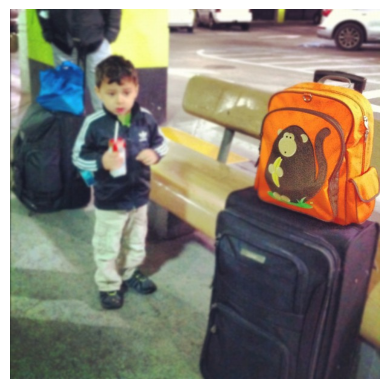

In [ ]:
annIds = vqa.getQuesIds(quesTypes='what animal is')
anns = vqa.loadQA(annIds)
randomAnn = random.choice(anns)
vqa.showQA([randomAnn])
imgId = randomAnn['image_id']
imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
imgpath = os.path.join(imgDir,imgFilename)
if os.path.isfile(imgpath):
	I = io.imread(imgpath)
	plt.imshow(I)
	plt.axis('off')
	plt.show()

**load and display QA annotations for given answer types**

Question: Is this a fast food meal?
Answer 1: yes
Answer 2: yes
Answer 3: yes
Answer 4: yes
Answer 5: yes
Answer 6: yes
Answer 7: yes
Answer 8: yes
Answer 9: yes
Answer 10: yes
Multiple Choice Answer: yes


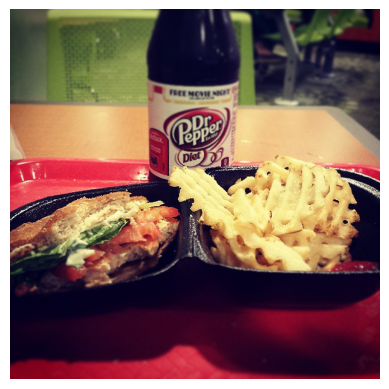

In [ ]:
annIds = vqa.getQuesIds(ansTypes='yes/no');
anns = vqa.loadQA(annIds)
randomAnn = random.choice(anns)
vqa.showQA([randomAnn])
imgId = randomAnn['image_id']
imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
imgpath = os.path.join(imgDir,imgFilename)
if os.path.isfile(imgpath):
	I = io.imread(imgpath)
	plt.imshow(I)
	plt.axis('off')
	plt.show()

**load and display QA annotations for given images**

Question: Is the kite off the ground?
Answer 1: yes
Answer 2: yes
Answer 3: yes
Answer 4: yes
Answer 5: yes
Answer 6: yes
Answer 7: yes
Answer 8: yes
Answer 9: yes
Answer 10: yes
Multiple Choice Answer: yes


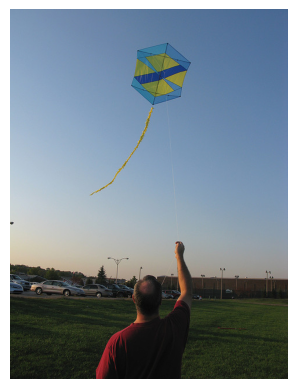

In [ ]:
ids = vqa.getImgIds()
annIds = vqa.getQuesIds(imgIds=random.sample(ids,5));
anns = vqa.loadQA(annIds)
randomAnn = random.choice(anns)
vqa.showQA([randomAnn])
imgId = randomAnn['image_id']
imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
imgpath = os.path.join(imgDir,imgFilename)
if os.path.isfile(imgpath):
	I = io.imread(imgpath)
	plt.imshow(I)
	plt.axis('off')
	plt.show()



---

# Data set translation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/
!mkdir /content/drive/MyDrive/translated-dataset

/content
mkdir: cannot create directory ‘/content/drive/MyDrive/translated-dataset’: File exists


In [ ]:
%cd /content/drive/MyDrive/translated-dataset/

/content/drive/MyDrive/translated-dataset


In [ ]:
!pip --q install deep_translator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.2 MB/s eta 0:00:00


In [ ]:
!pip --q install pandarallel

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.4 MB/s eta 0:00:00


In [ ]:
from deep_translator import GoogleTranslator
from pandarallel import pandarallel
import pandas as pd

In [ ]:
translator = GoogleTranslator(source='auto', target='ar')



---
**Questions Translation**


In [ ]:
questionsdf = pd.DataFrame(vqa.questions['questions'])
questionsdf.head()

,image_id,question,question_id
0,458752,What is this photo taken looking through?,458752000
1,458752,What position is this man playing?,458752001
2,458752,What color is the players shirt?,458752002
3,458752,Is this man a professional baseball player?,458752003
4,262146,What color is the snow?,262146000


In [ ]:
questionsdf.shape

(443757, 3)

In [ ]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
%%time
questionsdf['question'] = questionsdf.question.parallel_apply(translator.translate)

RequestError: Request exception can happen due to an api connection error. Please check your connection and try again

In [ ]:
questionsdf.head()

,image_id,question,question_id
0,458752,What is this photo taken looking through?,458752000
1,458752,What position is this man playing?,458752001
2,458752,What color is the players shirt?,458752002
3,458752,Is this man a professional baseball player?,458752003
4,262146,What color is the snow?,262146000


In [ ]:
vqa.questions['questions'][0]

{'image_id': 458752,
 'question': 'What is this photo taken looking through?',
 'question_id': 458752000}

In [ ]:
questionsdf.iloc[0]

image_id                                          458752
question       What is this photo taken looking through?
question_id                                    458752000
Name: 0, dtype: object

**`save`**

In [ ]:
vqa.questions['questions'] = questionsdf.to_dict('records')
with open(f'translated_{quesFile}', 'w') as f:
    json.dump(vqa.questions, f)

In [ ]:
json.load(open(f'translated_{quesFile}','r'))

{'info': {'description': 'This is v2.0 of the VQA dataset.',
  'url': 'http://visualqa.org',
  'version': '2.0',
  'year': 2017,
  'contributor': 'VQA Team',
  'date_created': '2017-04-26 17:07:13'},
 'task_type': 'Open-Ended',
 'data_type': 'mscoco',
 'license': {'url': 'http://creativecommons.org/licenses/by/4.0/',
  'name': 'Creative Commons Attribution 4.0 International License'},
 'data_subtype': 'train2014',
 'questions': [{'image_id': 458752,
   'question': 'What is this photo taken looking through?',
   'question_id': 458752000},
  {'image_id': 458752,
   'question': 'What position is this man playing?',
   'question_id': 458752001},
  {'image_id': 458752,
   'question': 'What color is the players shirt?',
   'question_id': 458752002},
  {'image_id': 458752,
   'question': 'Is this man a professional baseball player?',
   'question_id': 458752003},
  {'image_id': 262146,
   'question': 'What color is the snow?',
   'question_id': 262146000},
  {'image_id': 262146,
   'question'

---
**Annotations Translation**

In [ ]:
x

In [ ]:
def annTranslation(ann):

  m = ann
  df=pd.DataFrame(m)['answer'].to_frame()
  lst = df.values.tolist()
  lsttran = translator.translate_batch(lst)
  df['answer']=lsttran
  mm=df.to_dict('records')
  return mm



In [ ]:
annotationsdf = pd.DataFrame(vqa.annotations['annotations'])
annotationsdf.head()

In [ ]:
annotationsdf.shape

In [ ]:
pandarallel.initialize(nb_workers=5,progress_bar=True)

In [ ]:
%%time
annotationsdf['multiple_choice_answer_tran'] = annotationsdf['multiple_choice_answer'].parallel_apply(translator.translate)

In [ ]:
annotationsdf.head()

In [ ]:
vqa.annotations['annotations'] = annotationsdf.to_dict('records')
with open(f'translated_{annFile}', 'w') as f:
  json.dump(vqa.annotations, f)



---



In [ ]:
pandarallel.initialize(nb_workers=5,progress_bar=True)

In [ ]:
%%time
annotationsdf['answers'] = annotationsdf['answers'].parallel_apply(annTranslation)

In [ ]:
annotationsdf.head()

In [ ]:
vqa.annotations['annotations'][0]

In [ ]:
annotationsdf.iloc[0]

**`save`**

In [ ]:
vqa.annotations['annotations'] = annotationsdf.to_dict('records')
with open(f'translated_{annFile}', 'w') as f:
    json.dump(vqa.annotations, f)

In [ ]:
json.load(open(f'translated_{annFile}','r'))